In [3]:
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import GaussianFilter
import torch
import matplotlib.pyplot as plt
import pydicom

In [4]:
! python --version

Python 3.12.3


Initialize paths to where data is stored:

In [6]:
# initialize the `path`` variable below to specify the location of the required data
path = 'C:/Users/admin/Desktop/to luke/700'
path_CT = 'C:/Users/admin/Desktop/to luke/700'
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT) if 'CTAC5mm' in file]
file_NM = os.path.join(path, 'SGATE_G_1001_DS (original).dcm')

Load metadata/data:

In [7]:
object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=0)
projections = dicom.get_projections(file_NM)
mask = (projections>0)

The shape of the projections:
* The first dimension is the time gate, the second is angle, the last two are position on detector.

Load attenuation map and create attenuation transform:

In [8]:
att_transform = SPECTAttenuationTransform(filepath=files_CT)
att_transform.configure(object_meta, proj_meta)
attenuation_map = att_transform.attenuation_map

Let's compare the positioning of the attenuation map to the first projections

In [9]:
time_gate = 0
projection_number = 0

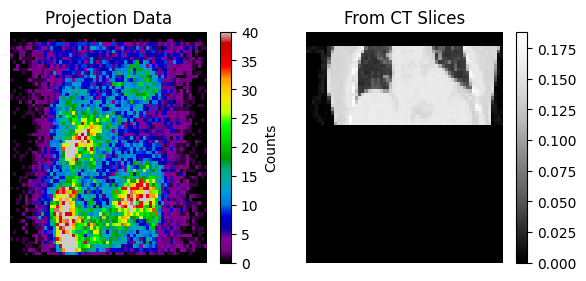

In [10]:
plt.subplots(1,2,figsize=(7,3))
plt.subplot(121)
plt.title('Projection Data')
plt.pcolormesh(projections[time_gate, projection_number].cpu().T, cmap='nipy_spectral',vmax=40)
plt.axis('off')
plt.colorbar(label='Counts')
plt.subplot(122)
plt.title('From CT Slices')
plt.pcolormesh(attenuation_map.cpu()[:,23].T, cmap='Greys_r')
plt.axis('off')
plt.colorbar()

Create PSF transform:
* need energy of the photons and type of collimator

In [11]:
collimator_name = 'GV-LEGP'
energy_kev = 140.5
psf_meta = dicom.get_psfmeta_from_scanner_params(collimator_name, energy_kev)
psf_transform = SPECTPSFTransform(psf_meta)

Follow reconstruction protocol:
1. Create system matrix
2. Create likelihood (give projections of the first time gate)
3. Create reconstruction algorithm

Then reconstruct using OSEM with 4 iterations and 8 subsets.

In [13]:
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform, psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)
likelihood = PoissonLogLikelihood(system_matrix, projections[time_gate])
reconstruction_algorithm = OSEM(likelihood)
reconstructed_object = reconstruction_algorithm(n_iters=4, n_subsets=8)
# filter = GaussianFilter(1.2) # .4 cm FWHM
# filter.configure(object_meta, proj_meta)
# reconstructed_object_filtered = filter(reconstructed_object)

Only take slices where CT is acquired:

In [14]:
valid_slices = attenuation_map.sum(dim=(0,1))>0
reconstructed_object = reconstructed_object[:,:,valid_slices]

22 slices are in this region:

In [15]:
reconstructed_object.shape

torch.Size([64, 64, 22])

Let's plot the reconstruction:

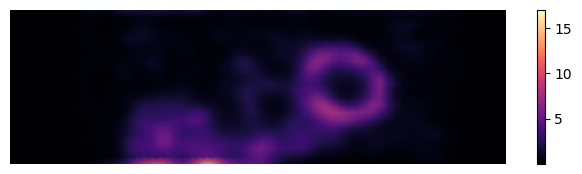

In [16]:
plt.figure(figsize=(8,2))
plt.pcolormesh(reconstructed_object[:,19].cpu().T, cmap='magma', vmax=17, shading='gouraud')
plt.colorbar()
plt.axis('off')
plt.show()

Now we can reconstruct all time gates:

In [19]:
def reconstruct(time_gate):
    system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)
    likelihood = PoissonLogLikelihood(system_matrix, projections[time_gate])
    reconstruction_algorithm = OSEM(likelihood)
    reconstructed_object = reconstruction_algorithm(n_iters=4, n_subsets=8)
    reconstructed_object = reconstructed_object[:,:,valid_slices]
    return reconstructed_object

In [17]:
reconstructed_objects = [reconstruct(i) for i in range(8)]

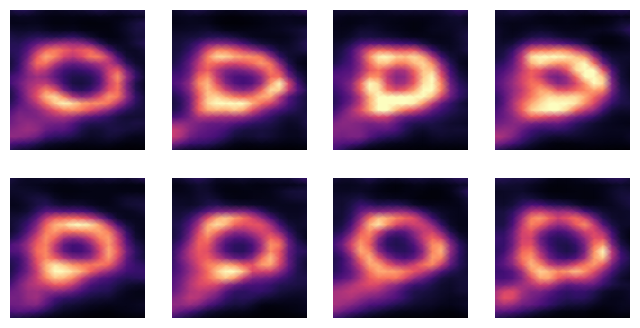

In [20]:
fig, axes = plt.subplots(2,4,figsize=(8,4))
for i in range(8):
    ax = axes.ravel()[i]
    ax.pcolormesh(reconstructed_objects[i][:,19].cpu().T, cmap='magma', vmax=8, shading='gouraud')
    ax.set_xlim(35,50)
    ax.axis('off')
plt.show()

# Potential way to mask?

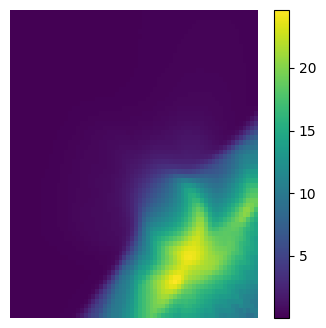

In [29]:
time_gate = 0
file_NM_masked = os.path.join(path, 'SGATE_G_1001_DS_N.dcm')
projections_mask = (dicom.get_projections(file_NM_masked)>0).to(torch.float32)
mask_3D = system_matrix.backward(projections_mask[time_gate].to(torch.float32))
plt.figure(figsize=(4,4))
plt.pcolormesh(mask_3D[:,:,50].cpu().T)
plt.colorbar()
plt.axis('off')
plt.show()

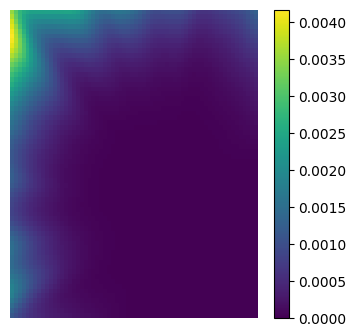

In [38]:
time_gate = 0
file_NM_masked = os.path.join(path, 'SGATE_G_1001_DS_N.dcm')
projections_mask = (dicom.get_projections(file_NM_masked)>0).to(torch.float32)
mask_3D = system_matrix.backward(projections_mask[time_gate].to(torch.float32))
plt.figure(figsize=(4,4))
plt.pcolormesh(mask_3D[:,:,63].cpu().T)
plt.colorbar()
plt.axis('off')
plt.show()

In [36]:
mask_3D.shape

torch.Size([64, 64, 64])